# Imports

In [1]:
%cd ..

/grad/bzhang388/pisp/physics_aware_diffusion


/grad/bzhang388/anaconda3/envs/jaxflax/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import functools
import utils
import fstars 
import fstar_net
import os

from clu import metric_writers
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import optax
import orbax.checkpoint as ocp

import h5py
import natsort
import tensorflow as tf
from scipy.ndimage import geometric_transform
from scipy.ndimage import gaussian_filter

from swirl_dynamics import templates
from swirl_dynamics.lib import diffusion as dfn_lib
from swirl_dynamics.lib import solvers as solver_lib
from swirl_dynamics.projects import probabilistic_diffusion as dfn

2024-06-24 12:05:58.870048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
jax.devices()
tf.config.set_visible_devices([], device_type='GPU')

# Dataset

In [4]:
# Parameters for the computational task.

L = 4 # number of levels (even number)
s = 5 # leaf size
r = 3 # rank

# Discretization of Omega (n_eta * n_eta).
neta = (2**L)*s

# Number of sources/detectors (n_sc).
# Discretization of the domain of alpha in polar coordinates (n_theta * n_rho).
# For simplicity, these values are set equal (n_sc = n_theta = n_rho), facilitating computation.
nx = (2**L)*s

# Standard deviation for the Gaussian blur.
blur_sigma = 0.5

# Number of training datapoints.
NTRAIN = 21000

# Number of testing datapoints.
NTEST = 500

# Total number
NTOTAL = NTRAIN + NTEST


In [6]:
name = '../data/fastmri80'

with h5py.File(f'{name}/scatter_20_hz.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())
    # Process real part of scatter data
    tmp4r = f[keys[1]][:NTRAIN, :]
    # Process imaginary part of scatter data
    tmp4i = f[keys[0]][:NTRAIN, :]

In [9]:
name = '../data/fastmri80'

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta80.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTRAIN, :].reshape((-1,neta,neta))
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re = np.stack([blur_fn(eta_re[i, :, :].T) for i in range(NTRAIN)]).astype('float32')
    
mean_eta = np.mean(eta_re, axis = 0)
eta_re -= mean_eta
std_eta = np.std(eta_re)
eta_re /= std_eta

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTRAIN, :]
    tmp2 = f[keys[4]][:NTRAIN, :]
    tmp3 = f[keys[5]][:NTRAIN, :]
    scatter_re = np.stack((tmp1, tmp2, tmp3, tmp4r), axis=-1)

    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTRAIN, :]
    tmp2 = f[keys[1]][:NTRAIN, :]
    tmp3 = f[keys[2]][:NTRAIN, :]
    scatter_im = np.stack((tmp1, tmp2, tmp3, tmp4i), axis=-1)
    
    # Combine real and imaginary parts
    scatter = np.stack((scatter_re, scatter_im), axis=-2).astype('float32')

mean0, std0 = np.mean(scatter[:,:,:,0]), np.std(scatter[:,:,:,0])
mean1, std1 = np.mean(scatter[:,:,:,1]), np.std(scatter[:,:,:,1])
mean2, std2 = np.mean(scatter[:,:,:,2]), np.std(scatter[:,:,:,2])
mean3, std3 = np.mean(scatter[:,:,:,3]), np.std(scatter[:,:,:,3])

scatter[:,:,:,0] -= mean0
scatter[:,:,:,0] /= std0
scatter[:,:,:,1] -= mean1
scatter[:,:,:,1] /= std1
scatter[:,:,:,2] -= mean2
scatter[:,:,:,2] /= std2
scatter[:,:,:,3] -= mean3
scatter[:,:,:,3] /= std3

# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3, tmp4r, tmp4i


In [10]:
eta_train = eta_re.reshape(-1, 80, 80, 1)
scatter_train = scatter.reshape(-1, 6400, 2, 4)

In [11]:
# To avoid tf to use GPU memory

batch_size = 16
dict_data = {"x": eta_train}
dict_data["cond"] = {"channel:scatter0": scatter_train[:,:,:,0],
                     "channel:scatter1": scatter_train[:,:,:,1],
                     "channel:scatter2": scatter_train[:,:,:,2],
                     "channel:scatter3": scatter_train[:,:,:,3],}
dataset = tf.data.Dataset.from_tensor_slices(dict_data)
dataset = dataset.shuffle(NTRAIN) 
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.AUTOTUNE)
dataset = dataset.as_numpy_iterator()

# Architecture

The architecture is similar to the unconditional case. We provide additional args that specify how to resize the conditioning signal (in order to be compatible with the noisy sample for channel-wise concatenation).

In [12]:
r_index = utils.rotationindex(nx)
cart_mat = utils.SparsePolarToCartesian(neta, nx)

2024-06-22 01:13:55.158105: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [13]:
import importlib
importlib.reload(fstars)

<module 'fstars' from '/grad/bzhang388/pisp/physics_aware_diffusion/fstars.py'>

In [14]:
fstarlist = [fstars.uncompressed_fstar( 
    nx = nx, 
    neta = neta,
    cart_mat = cart_mat,
    r_index = r_index
) for i in range(4)]

In [15]:
del r_index, cart_mat

In [16]:
import importlib
importlib.reload(fstar_net)

<module 'fstar_net' from '/grad/bzhang388/pisp/physics_aware_diffusion/fstar_net.py'>

In [17]:
cond_denoiser_model = fstar_net.PreconditionedDenoiser(
    fstars=fstarlist,
    out_channels=1,
    squeeze_ratio=8,
    cond_embed_iter=10, 
    noise_embed_dim=96, 
    num_conv=8,
    num_feature=96, # multiples of 32
)

In [18]:
diffusion_scheme = dfn_lib.Diffusion.create_variance_preserving(
    sigma=dfn_lib.tangent_noise_schedule(),
    data_std=1, # we always use normalized data
)

cond_model = dfn.DenoisingModel(
    input_shape=(80,80,1),
    cond_shape={"channel:scatter0": (6400,2),
                "channel:scatter1": (6400,2),
                "channel:scatter2": (6400,2),
                "channel:scatter3": (6400,2)},
    denoiser=cond_denoiser_model,
    noise_sampling=dfn_lib.time_uniform_sampling(
        diffusion_scheme, clip_min=1e-4, uniform_grid=True,
    ),
    noise_weighting=dfn_lib.edm_weighting(data_std=1),
)

In [19]:
epochs = 120
num_train_steps = 21000 * epochs // 16  #@param
cond_workdir = os.path.abspath('') + "/tmp/diffusion_uncompressed_fastmri_80_high"
initial_lr = 1e-5 #@param
peak_lr = 5e-4 #@pawram
warmup_steps = num_train_steps // 20  #@param
end_lr = 1e-8 #@param
ema_decay = 0.999  #@param
ckpt_interval = 2000 #@param
max_ckpt_to_keep = 3 #@param

In [20]:
rng = jax.random.PRNGKey(888)
params = cond_model.initialize(rng)
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
print('Number of trainable parameters:', param_count)

Number of trainable parameters: 583341


In [21]:
def count_params(params, parent_name=''):
    """ Recursively count the number of parameters in the JAX model. """
    total_params = 0
    for key, value in params.items():
        layer_name = f"{parent_name}/{key}" if parent_name else key
        if isinstance(value, dict):
            # Recurse into nested dictionary
            layer_params = count_params(value, layer_name)
            total_params += layer_params
        else:
            # Assume value is a parameter array
            layer_params = value.size
            total_params += layer_params
            print(f"Layer: {layer_name}, Parameters: {layer_params}")
    return total_params

total_parameters = count_params(params)
print(f"Total parameters in the model: {total_parameters}")


Layer: params/fstars_0/pre1, Parameters: 80
Layer: params/fstars_0/pre2, Parameters: 80
Layer: params/fstars_0/pre3, Parameters: 80
Layer: params/fstars_0/pre4, Parameters: 80
Layer: params/fstars_0/post1, Parameters: 80
Layer: params/fstars_0/post2, Parameters: 80
Layer: params/fstars_0/post3, Parameters: 80
Layer: params/fstars_0/post4, Parameters: 80
Layer: params/fstars_0/cos_kernel1, Parameters: 6400
Layer: params/fstars_0/sin_kernel1, Parameters: 6400
Layer: params/fstars_0/cos_kernel2, Parameters: 6400
Layer: params/fstars_0/sin_kernel2, Parameters: 6400
Layer: params/fstars_0/cos_kernel3, Parameters: 6400
Layer: params/fstars_0/sin_kernel3, Parameters: 6400
Layer: params/fstars_0/cos_kernel4, Parameters: 6400
Layer: params/fstars_0/sin_kernel4, Parameters: 6400
Layer: params/fstars_1/pre1, Parameters: 80
Layer: params/fstars_1/pre2, Parameters: 80
Layer: params/fstars_1/pre3, Parameters: 80
Layer: params/fstars_1/pre4, Parameters: 80
Layer: params/fstars_1/post1, Parameters: 80

# Training

In [22]:
cond_trainer = dfn.DenoisingTrainer(
    model=cond_model,
    rng=jax.random.PRNGKey(888),
    optimizer=optax.adam(
        learning_rate=optax.warmup_cosine_decay_schedule(
            init_value=initial_lr,
            peak_value=peak_lr,
            warmup_steps=warmup_steps,
            decay_steps=num_train_steps,
            end_value=end_lr,
        ),
    ),
    ema_decay=ema_decay,
)

In [23]:
templates.run_train(
    train_dataloader=dataset,
    trainer=cond_trainer,
    workdir=cond_workdir,
    total_train_steps=num_train_steps,
    metric_writer=metric_writers.create_default_writer(
        cond_workdir, asynchronous=False
    ),
    metric_aggregation_steps = 100,
    callbacks=(
        templates.TqdmProgressBar(
            total_train_steps=num_train_steps,
            train_monitors=("train_loss",),
        ),
        templates.TrainStateCheckpoint(
            base_dir=cond_workdir,
            options=ocp.CheckpointManagerOptions( 
                save_interval_steps=ckpt_interval, max_to_keep=max_ckpt_to_keep
            ),
        ),
    ),
)

  0%|          | 0/157500 [00:00<?, ?step/s]

# Inference

In [39]:
trained_state = dfn.DenoisingModelTrainState.restore_from_orbax_ckpt(
    f"{cond_workdir}/checkpoints", step=None
)

# Construct the inference function
cond_denoise_fn = dfn.DenoisingTrainer.inference_fn_from_state_dict(
    trained_state, use_ema=True, denoiser=cond_denoiser_model
)

In [40]:
cond_sampler = dfn_lib.SdeSampler(
    input_shape=(80,80,1),
    integrator=solver_lib.EulerMaruyama(),
    tspan=dfn_lib.exponential_noise_decay(diffusion_scheme, num_steps=256, end_sigma=1e-3,),
    scheme=diffusion_scheme,
    denoise_fn=cond_denoise_fn,
    guidance_transforms=(),
    apply_denoise_at_end=True,
    return_full_paths=False,
)

We again JIT the generate function for the sake of faster repeated sampling calls. Here we employ `functools.partial` to specify `num_samples=5`, making it easier to vectorize across the batch dimension with `jax.vmap`.

In [41]:
num_samples_per_cond = 1

generate = jax.jit(
    functools.partial(cond_sampler.generate, num_samples_per_cond)
)

In [42]:
NTEST = 100 # Change it!

In [43]:
name = '../data/fastmri_testdata'

with h5py.File(f'{name}/scatter_order_8_high.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())
    # Process real part of scatter data
    tmp4r = f[keys[1]][:NTEST, :]
    # Process imaginary part of scatter data
    tmp4i = f[keys[0]][:NTEST, :]

Loading a test batch of conditions with 4 elements:

In [44]:

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta80_test.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTEST, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re = np.stack([blur_fn(img.T) for img in eta_re]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter_order_8.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTEST, :]
    tmp2 = f[keys[4]][:NTEST, :]
    tmp3 = f[keys[5]][:NTEST, :]
    scatter_re = np.stack((tmp1, tmp2, tmp3, tmp4r), axis=-1)

    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTEST, :]
    tmp2 = f[keys[1]][:NTEST, :]
    tmp3 = f[keys[2]][:NTEST, :]
    scatter_im = np.stack((tmp1, tmp2, tmp3, tmp4i), axis=-1)
    
    # Combine real and imaginary parts
    scatter = np.stack((scatter_re, scatter_im), axis=-2).astype('float32')
    
scatter[:,:,:,0] -= mean0
scatter[:,:,:,0] /= std0
scatter[:,:,:,1] -= mean1
scatter[:,:,:,1] /= std1
scatter[:,:,:,2] -= mean2
scatter[:,:,:,2] /= std2
scatter[:,:,:,3] -= mean3
scatter[:,:,:,3] /= std3

# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3, tmp4r, tmp4i

In [45]:
eta_test = eta_re.reshape(-1, 80, 80, 1)
scatter_test = scatter.reshape(-1, 6400, 2, 4) 
#scatter_test = np.swapaxes(scatter_test,1,2).reshape(-1, 6400, 2, 3)
#c = 0.4
#scatter_test += np.random.normal(0,c,size=scatter_test.shape)

In [46]:
batch_size_test = 20
dict_data_test = {}
dict_data_test["cond"] = {"channel:scatter0": scatter_test[:,:,:,0],
                          "channel:scatter1": scatter_test[:,:,:,1],
                          "channel:scatter2": scatter_test[:,:,:,2],
                          "channel:scatter3": scatter_test[:,:,:,3]}

dataset_test = tf.data.Dataset.from_tensor_slices(dict_data_test)
dataset_test = dataset_test.batch(batch_size_test)
dataset_test = dataset_test.prefetch(tf.data.AUTOTUNE)
dataset_test = dataset_test.as_numpy_iterator()

In [48]:
eta_pred = np.zeros((NTEST, num_samples_per_cond, neta, neta, 1))

b = 0
for batch in dataset_test:
    print(b)
    cond_samples = jax.device_get(jax.vmap(generate, in_axes=(0, 0, None))(
        jax.random.split(jax.random.PRNGKey(68), batch_size_test),
        batch["cond"],
        None,  # Guidance inputs = None since no guidance transforms involved
    ))
    eta_pred[b*batch_size_test:(b+1)*batch_size_test,:,:,:,:] = cond_samples*std_eta+mean_eta[:, :, jnp.newaxis]
    b += 1


0
1
2
3
4


2024-06-22 07:41:46.144710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [49]:
errors = []
for i in range(NTEST):
    for j in range(num_samples_per_cond):
        errors.append(np.linalg.norm(eta_test[i,:,:,0]-eta_pred[i,0,:,:,0])/np.linalg.norm(eta_test[i,:,:,0]))
        
print('Mean of validation relative l2 error:', np.mean(errors))
print('Median of validation relative l2 error:', np.median(errors))
print('Min of validation relative l2 error:', np.min(errors))
print('Max of validation relative l2 error:', np.max(errors))
print('Standard deviation of validation relative l2 errors:', np.std(errors))


Mean of validation relative l2 error: 0.04341072657375914
Median of validation relative l2 error: 0.04337955866759163
Min of validation relative l2 error: 0.02572122177002759
Max of validation relative l2 error: 0.06245878885292429
Standard deviation of validation relative l2 errors: 0.010161245436142434


In [50]:
errors

[0.050329212967210525,
 0.04923609116992855,
 0.05355916845734822,
 0.059809718112785765,
 0.04937350373375044,
 0.02884426482551107,
 0.048020445692537085,
 0.05150329613392988,
 0.05532722078057223,
 0.036467874877467464,
 0.030139548128583542,
 0.0529338583955579,
 0.03188973842968824,
 0.03836272458842562,
 0.061759269941621744,
 0.02853393042588329,
 0.05147510497191686,
 0.029216517917840645,
 0.0373318233340324,
 0.03877773816302583,
 0.04186784603553681,
 0.04615183980942668,
 0.02572122177002759,
 0.05600824391349234,
 0.047038723454709344,
 0.04258336681743062,
 0.043028612057550646,
 0.02576400813029989,
 0.0358206015725674,
 0.05068451794702232,
 0.042813057106983875,
 0.03226111317587,
 0.04827358970618305,
 0.038813382436716184,
 0.04204332262691624,
 0.05443292693401655,
 0.05179711979206665,
 0.049139126328413135,
 0.032431869543736475,
 0.033262846051408466,
 0.03790036504074591,
 0.036705311958813096,
 0.04887732345478141,
 0.02987032595709975,
 0.05767486529131978,
 

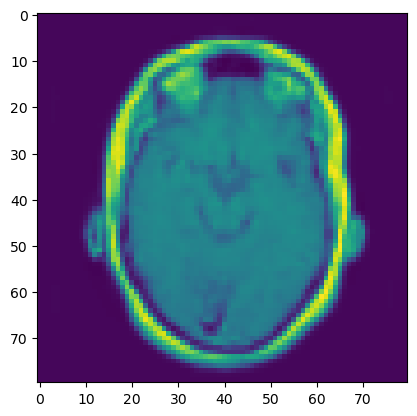

In [51]:
plt.imshow(eta_pred[i,0,:,:,0])

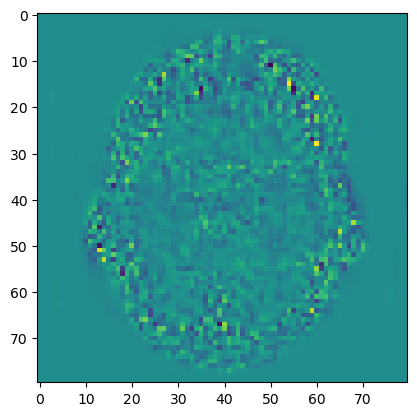

In [55]:
plt.imshow(eta_pred[i,0,:,:,0]-eta_test[-1,:,:,0])

In [53]:
#import matplotlib.pyplot as plt
#import numpy as np
#
## Assuming ground_truth and samples are already loaded as NumPy arrays
## Example initialization (replace with your actual image arrays)
## ground_truth = np.random.rand(256, 256, 3)  # Example ground truth image
## samples = [np.random.rand(128, 128, 3) for _ in range(4)]  # Example smaller sample images
#
## Plotting
#fig = plt.figure(figsize=(12, 6))  # Adjust figure size as needed
#
## Add ground truth plot
#ax1 = fig.add_subplot(2, 3, 1)  # 2 rows, 3 columns, 1st position spans all rows
#ax1.imshow(eta_test[3,:,:,0])
#ax1.set_title('Ground Truth')
#ax1.axis('off')  # Hide axes
#
#ax2 = fig.add_subplot(2, 3, 2)  # 2 rows, 3 columns, start placing at 3rd position
#ax2.imshow(eta_pred1[3,0,:,:,0])
#ax2.set_title('5% noise')
#ax2.axis('off')  # Hide axes
#ax2 = fig.add_subplot(2, 3, 3)  # 2 rows, 3 columns, start placing at 3rd position
#ax2.imshow(eta_pred3[3,0,:,:,0])
#ax2.set_title('20% noise')
#ax2.axis('off')  # Hide axes
#ax2 = fig.add_subplot(2, 3, 4)  # 2 rows, 3 columns, start placing at 3rd position
#ax2.imshow(eta_pred0[3,0,:,:,0])
#ax2.set_title('0% noise')
#ax2.axis('off')  # Hide axes
#ax2 = fig.add_subplot(2, 3, 5)  # 2 rows, 3 columns, start placing at 3rd position
#ax2.imshow(eta_pred2[3,2,:,:,0])
#ax2.set_title('10% noise')
#ax2.axis('off')  # Hide axes
#ax2 = fig.add_subplot(2, 3, 6)  # 2 rows, 3 columns, start placing at 3rd position
#ax2.imshow(eta_pred4[3,3,:,:,0])
#ax2.set_title('40% noise')
#ax2.axis('off')  # Hide axes
#
#plt.tight_layout()  # Adjust layout so that plots are not overlapping
#plt.show()
#fig.savefig("noise.jpg")

In [68]:
#with h5py.File("results_diffusion_uncompressed_squares_final.h5", "w") as f:
#    f.create_dataset('eta', data=eta_test)
#    f.create_dataset('eta_pred', data=eta_pred)

In [69]:
#with h5py.File("results_diffusion_uncompressed_squares.h5", "w") as f:
#    f.create_dataset('eta', data=eta_test)
#    f.create_dataset('eta_pred', data=eta_pred)